In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import STL

# -------------------------------------
# Load and Prepare Data
# -------------------------------------
df = pd.read_csv("cleaned_imputed_weather_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

target_col = 'Imputed_Wind_Speed_Max_Gust'
target = df[target_col].copy()

# -------------------------------------
# Z-Score Based Outlier Detection
# -------------------------------------
def detect_outliers_zscore(series, threshold=3.0):
    mean = series.mean()
    std = series.std()
    z_scores = (series - mean) / std
    return list(np.where(np.abs(z_scores) > threshold)[0])

outlier_indices = detect_outliers_zscore(target, threshold=2)
print(f"🔍 Detected {len(outlier_indices)} outliers using Z-score method.")

# -------------------------------------
# Create masked copy with NaNs
# -------------------------------------
masked = target.copy()
masked.iloc[outlier_indices] = np.nan

# -------------------------------------
# 1. Linear Interpolation
# -------------------------------------
df['cleaned_linear'] = masked.interpolate(method='linear')

# -------------------------------------
# 2. KNN Imputation
# -------------------------------------
df_knn = df[[target_col]].copy()
df_knn.iloc[outlier_indices] = np.nan
imputer = KNNImputer(n_neighbors=5)
df['cleaned_knn'] = imputer.fit_transform(df_knn)

# -------------------------------------
# 3. Rolling Median
# -------------------------------------
mask = pd.Series(False, index=df.index)
mask.iloc[outlier_indices] = True
df['cleaned_rolling'] = target.mask(mask).fillna(
    target.rolling(window=5, center=True).median()
)

# -------------------------------------
# 4. Time-aware Interpolation
# -------------------------------------
df_time = df.set_index('Date')
masked_time = df_time[target_col].copy()
masked_time.iloc[outlier_indices] = np.nan
df_time['cleaned_time_interp'] = masked_time.interpolate(method='time')
df = df_time.reset_index()

# -------------------------------------
# 5. Smart Peak-Preserving Imputation
# -------------------------------------
def smart_impute_peaks(series, outlier_idx, window=7):
    series_cleaned = series.copy()
    for i in outlier_idx:
        if i < window or i + window >= len(series):
            continue
        local = series[i - window:i + window + 1].drop(series.index[i])
        upper_quartile = local.quantile(0.75)
        nearby_peaks = local[local >= upper_quartile]
        series_cleaned.iloc[i] = nearby_peaks.mean() if len(nearby_peaks) > 0 else local.median()
    return series_cleaned

df['cleaned_smart_peak'] = smart_impute_peaks(target, outlier_indices)

# -------------------------------------
# 6. STL Decomposition + Residual Imputation
# -------------------------------------
stl_series = target.copy()
stl_series.iloc[outlier_indices] = np.nan
stl_series.index = df['Date']

stl_result = STL(stl_series, period=30, robust=True).fit()
residual = stl_result.resid
residual_interp = residual.interpolate(method='linear')
df['cleaned_stl'] = (stl_result.trend + stl_result.seasonal + residual_interp).values

# -------------------------------------
# 7. Spline Interpolation
# -------------------------------------
df['cleaned_spline'] = masked.interpolate(method='spline', order=3)


🔍 Detected 208 outliers using Z-score method.


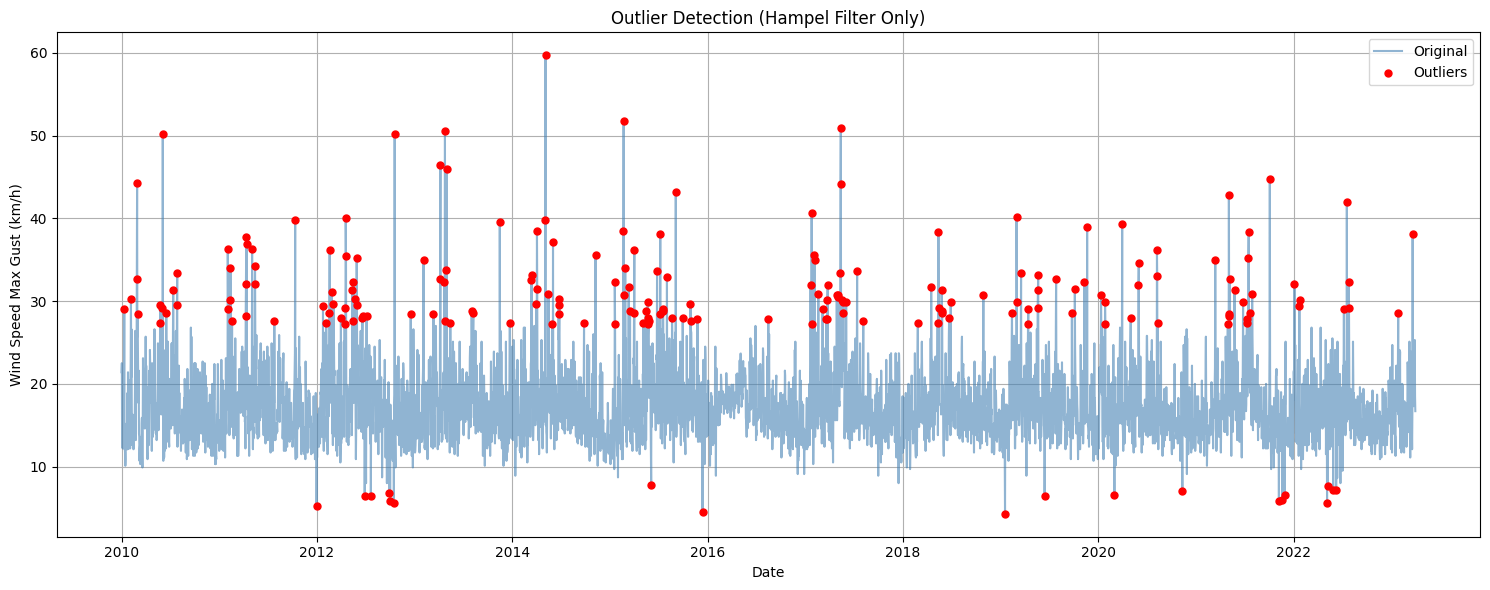

In [ ]:
import matplotlib.pyplot as plt

# 📌 Ensure these are defined:
# - df['Date'] – datetime column
# - df[target_col] – original signal
# - outlier_indices – list of Hampel-detected outlier positions

plt.figure(figsize=(15, 6))

# Plot original data
plt.plot(df['Date'], df[target_col], label='Original', alpha=0.6, color='steelblue')

# Plot outliers
plt.scatter(df.loc[outlier_indices, 'Date'], df.loc[outlier_indices, target_col],
            color='red', label='Outliers', s=25, zorder=5)

plt.title("Outlier Detection (Hampel Filter Only)")
plt.xlabel("Date")
plt.ylabel("Wind Speed Max Gust (km/h)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


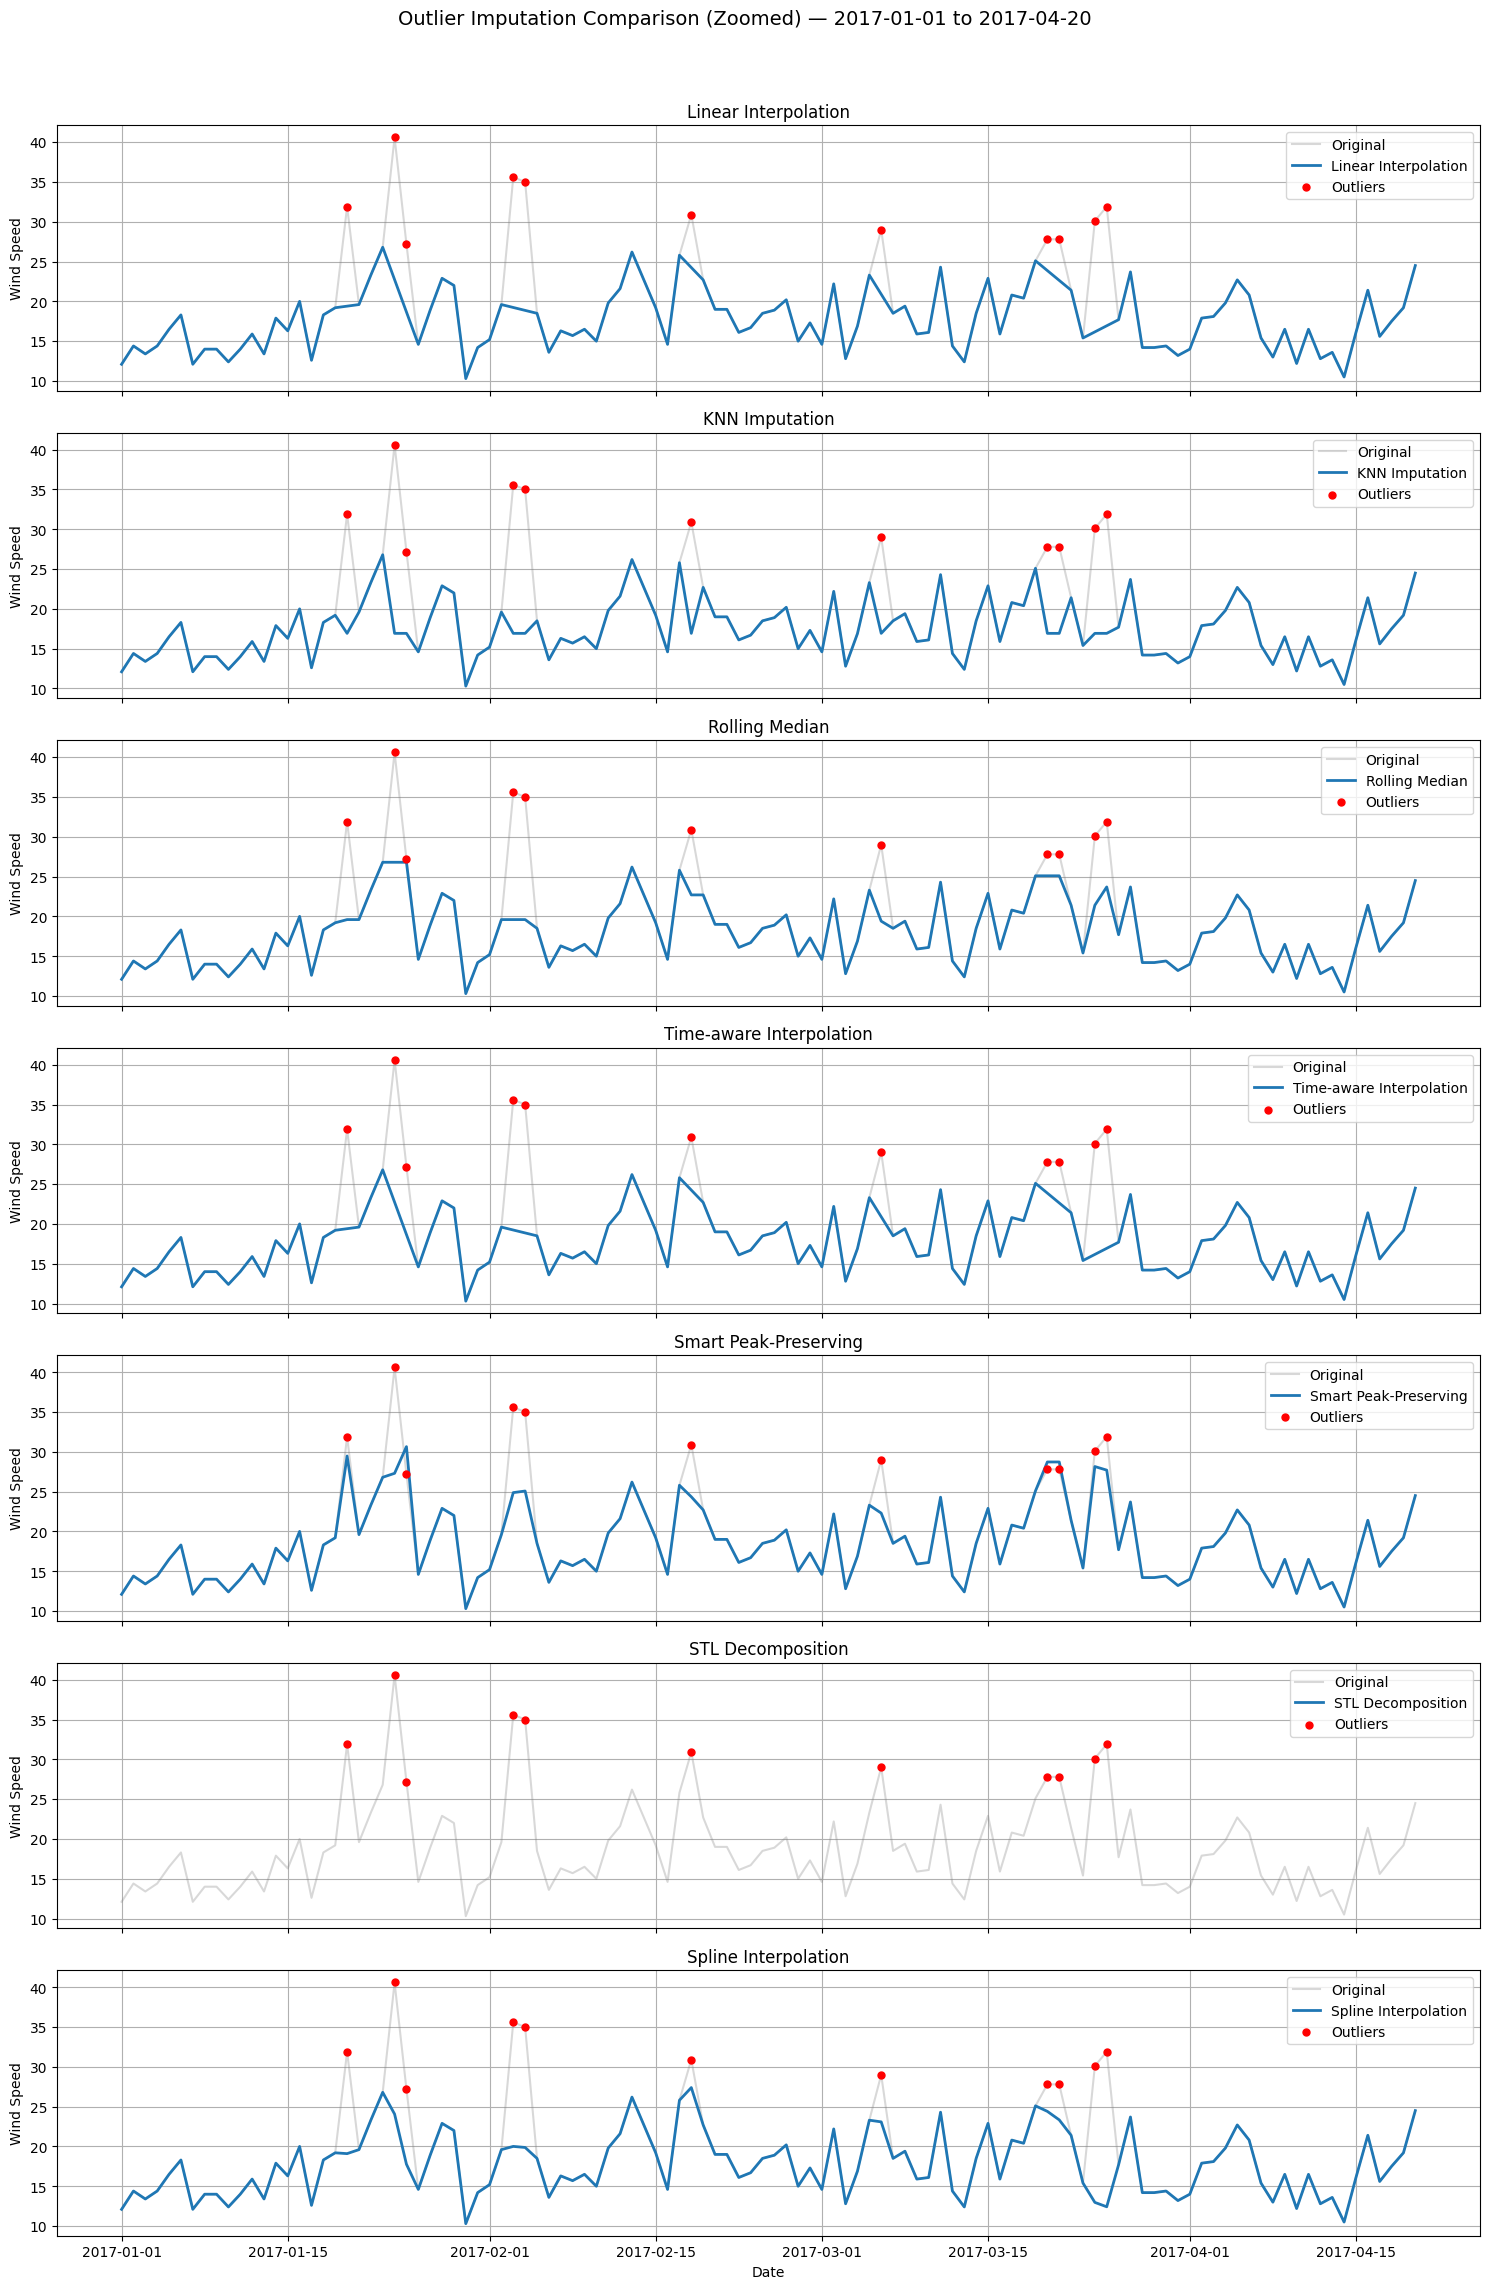

In [ ]:
import matplotlib.pyplot as plt

# -------------------------------
# Setup
# -------------------------------
start_date = '2017-01-01'
end_date = '2017-04-20'
zoom_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].copy()

# Method names to plot
methods = {
    "cleaned_linear": "Linear Interpolation",
    "cleaned_knn": "KNN Imputation",
    "cleaned_rolling": "Rolling Median",
    "cleaned_time_interp": "Time-aware Interpolation",
    "cleaned_smart_peak": "Smart Peak-Preserving",
    "cleaned_stl": "STL Decomposition",
    "cleaned_spline": "Spline Interpolation"
}

n_rows = len(methods)
fig, axes = plt.subplots(n_rows, 1, figsize=(15, 3.2 * n_rows), sharex=True)

# -------------------------------
# Plot each method
# -------------------------------
for ax, (col, title) in zip(axes, methods.items()):
    ax.plot(zoom_df['Date'], zoom_df[target_col], label='Original', alpha=0.3, color='gray')
    ax.plot(zoom_df['Date'], zoom_df[col], label=title, linewidth=2)

    zoom_outliers = zoom_df.index.intersection(outlier_indices)
    ax.scatter(zoom_df.loc[zoom_outliers, 'Date'],
               zoom_df.loc[zoom_outliers, target_col],
               color='red', label='Outliers', s=25, zorder=5)

    ax.set_ylabel("Wind Speed")
    ax.set_title(title)
    ax.grid(True)
    ax.legend(loc='upper right')

# -------------------------------
# Final layout
# -------------------------------
plt.xlabel("Date")
plt.suptitle(f"Outlier Imputation Comparison (Zoomed) — {start_date} to {end_date}", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   Date                              4838 non-null   datetime64[ns]
 1   Imputed_Air_Temperature_Mean      4838 non-null   float64       
 2   Imputed_Air_Temperature_Max       4838 non-null   float64       
 3   Imputed_Air_Temperature_Min       4838 non-null   float64       
 4   Imputed_Relative_Humidity_Mean    4838 non-null   float64       
 5   Imputed_Relative_Humidity_Max     4838 non-null   float64       
 6   Imputed_Relative_Humidity_Min     4838 non-null   float64       
 7   Imputed_Wind_Speed_Mean           4838 non-null   float64       
 8   Imputed_Wind_Speed_Max_Sustained  4838 non-null   float64       
 9   Imputed_Wind_Speed_Max_Gust       4838 non-null   float64       
 10  cleaned_linear                    4838 non-null 

In [ ]:
# Drop unwanted imputation columns
df.drop(columns=[
    'cleaned_linear',
    'cleaned_knn',
    'cleaned_rolling',
    'cleaned_time_interp',
    'cleaned_smart_peak',
    'cleaned_stl'
], inplace=True)

# Rename the spline-imputed column
df.rename(columns={
    'cleaned_spline': 'Imputed_Wind_Speed_Max_Gust_spline'
}, inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Date                                4838 non-null   datetime64[ns]
 1   Imputed_Air_Temperature_Mean        4838 non-null   float64       
 2   Imputed_Air_Temperature_Max         4838 non-null   float64       
 3   Imputed_Air_Temperature_Min         4838 non-null   float64       
 4   Imputed_Relative_Humidity_Mean      4838 non-null   float64       
 5   Imputed_Relative_Humidity_Max       4838 non-null   float64       
 6   Imputed_Relative_Humidity_Min       4838 non-null   float64       
 7   Imputed_Wind_Speed_Mean             4838 non-null   float64       
 8   Imputed_Wind_Speed_Max_Sustained    4838 non-null   float64       
 9   Imputed_Wind_Speed_Max_Gust         4838 non-null   float64       
 10  Imputed_Wind_Speed_Max_G

In [ ]:
# Save the cleaned DataFrame to a CSV file
df.to_csv("cleaned_weather_data_Z-Score_spline_imputed.csv", index=False)
